In [1]:
import pandas as pd
import numpy as np
import seaborn
from matplotlib import pyplot as plt
from tqdm import tqdm

from multiprocessing import Process, Manager

import sys
sys.path.append('./data/')
sys.path.append('./../')
import gen_lemonade_data
import training_util

# Import models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import lightgbm as lgb

# Import metrics
from sklearn.metrics import mean_squared_error

# Import OP Solvers
from pulp import LpProblem, LpStatus, lpSum, LpVariable, LpMinimize

In [2]:
def cost_function_1(y, z, c0, c1):
    return z*(c0 - c1) + c1*y

def cost_function_2(y, z, c0, c2):
    return z*(c0 + c2) - c2*y

def cost_function(y, z, c0, c1, c2):
    if y-z >= 0:
        return cost_function_1(y, z, c0, c1)
    else:
        return cost_function_2(y, z, c0, c1)
    
def cost_function_list(y_list, z_list, c0, c1, c2):
    cost_list = []
    for y, z in zip(y_list, z_list):
        cost_list.append(cost_function(y, z, c0, c1, c2))
    return cost_list
        
def SolOpt_1(y, c0, c1):
    t_Model = LpProblem(name="small-problem", sense=LpMinimize)
    z = LpVariable(name="z", lowBound=0)

    t_Model+=(y-z>=0,"cstr1")
    t_Model+=(z>=0,"cstr2")
    
    obj_func = cost_function_1(y, z, c0, c1)
    t_Model += obj_func
    status = t_Model.solve()
    var=t_Model.variables()
    return var[0].value(),t_Model.objective.value()


def SolOpt_2(y, c0, c2):
    t_Model = LpProblem(name="small-problem", sense=LpMinimize)
    z = LpVariable(name="z", lowBound=0)

    t_Model+=(z-y>=0,"cstr1")
    t_Model+=(z>=0,"cstr2")
    
    obj_func = cost_function_2(y, z, c0, c2)
    t_Model += obj_func
    status = t_Model.solve()
    var=t_Model.variables()
    return var[0].value(),t_Model.objective.value()

def SolOpt(y, c0, c1, c2, i, z_opt, f_opt):
    Result_1 = SolOpt_1(y, c0, c1)
    Result_2 = SolOpt_2(y, c0, c2)
    
    if Result_1[1] < Result_2[1]:
        Result = Result_1
    else:
        Result = Result_2
    z_opt[i] = Result[0]
    f_opt[i] = Result[1]
    
def run_solver(data_test, c0, c1, c2, model_type):
    
    y_col = 'y'
    z_col = 'z_opt_from_y'  
    if model_type != 'real':
        y_col = 'y_pred_{}'.format(model_type)
        z_col = 'z_opt_from_y_pred_{}'.format(model_type)
    
    manager = Manager()
    z_opt = manager.dict()
    f_opt = manager.dict()
    jobs = []
    for i in tqdm(range(0, len(data_test))):
        p = Process(target=SolOpt, 
                    args=(data_test[y_col].iloc[i], 
                          c0, c1, c2, i, z_opt, f_opt))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()

    df_solver = pd.DataFrame(
        data = {'ind':z_opt.keys(), 
                z_col:z_opt.values()}
                ).set_index('ind')

    data_test = pd.concat([data_test, df_solver], axis = 1)
    
    return data_test

In [3]:
# Data params
N = 6000
train_perc = 0.8

# Optimization Problem params
c0 = 10
c1 = 50
c2 = 30

Ntr, Nte, N
4800 1200 6000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 3
[LightGBM] [Info] Start training from score 256.840759
[100]	TR's l2: 146.697	VA's l2: 186.102
[200]	TR's l2: 23.5408	VA's l2: 38.3397
[300]	TR's l2: 14.1193	VA's l2: 25.7034
[400]	TR's l2: 10.2777	VA's l2: 20.828
[500]	TR's l2: 8.4028	VA's l2: 18.1636
[600]	TR's l2: 7.1368	VA's l2: 16.5214
[700]	TR's l2: 6.47913	VA's l2: 15.524
[800]	TR's l2: 5.83539	VA's l2: 14.6627
[900]	TR's l2: 5.21092	VA's l2: 13.9061
[1000]	TR's l2: 4.80839	VA's l2: 13.3

----------Results----------
MSE using linear model: 5621.934181960381
MSE using SVM regressor: 808.9723901918719
MSE using LGBM regressor: 14.322016907067676


Run solver

100%|██████████| 1200/1200 [01:56<00:00, 10.27it/s]


Run solver for lin


100%|██████████| 1200/1200 [01:56<00:00, 10.28it/s]


Run solver for svm


100%|██████████| 1200/1200 [01:55<00:00, 10.40it/s]


Run solver for gbm


100%|██████████| 1200/1200 [01:58<00:00, 10.17it/s]




Compute objective functions using decisions from models

----------Results----------
                       average_cost  median_cost
f_opt_from_y_pred_lin   5590.246640  5523.092790
f_opt_from_y_pred_svm   3438.755821  3372.226803
f_opt_from_y_pred_gbm   2679.186233  2670.349150
f_opt_from_y            2588.529424  2607.465329


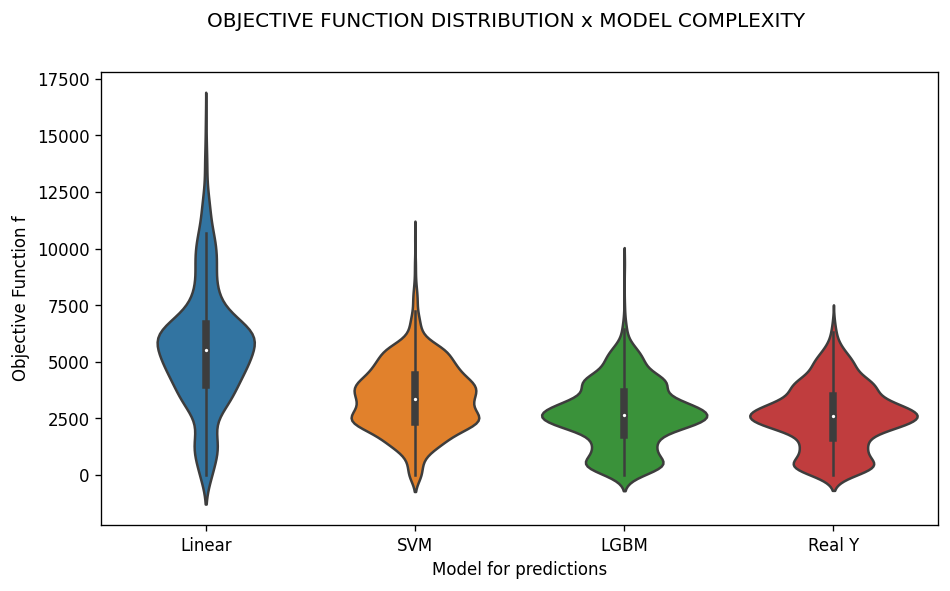

In [4]:
#########################################################################
##### Generate data for lemonade problem ################################
#########################################################################

data_lemonade = gen_lemonade_data.generate_lemonade_dataset(N = N)

Ntr = int(train_perc*N)
Nte = N - Ntr
print('Ntr, Nte, N')
print(Ntr, Nte, N)

data_train = data_lemonade.iloc[:Ntr, :].reset_index(drop=True).copy()
data_test = data_lemonade.iloc[Ntr:, :].reset_index(drop=True).copy()

feat_cols = ['x1','x2','x3']
target_col = ['y']



#########################################################################
##### Set hyperparams for models ########################################
#########################################################################

# Hyperparams for SVM
params_svm = {
    'C':1000
}

# Hyperparams for LGB
params_lgb = {
    'objective':'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.04,
    'max_depth':5,
    'num_leaves':7,
}



#########################################################################
##### Train: linear, SVM and LGB regressors #############################
#########################################################################

mdl_lin = training_util.train_linear(
    X_tr=data_train[feat_cols], y_tr=data_train[target_col])

mdl_svm = training_util.train_svm(
    X_tr=data_train[feat_cols], y_tr=data_train[target_col], 
    params=params_svm)

mdl_gbm = training_util.train_lgb(
    X_tr=data_train[feat_cols], y_tr=data_train[target_col], 
    params=params_lgb)



#########################################################################
##### Predict test data: linear, SVM and LGB regressors #################
#########################################################################

data_test.loc[:,'y_pred_lin'] = mdl_lin.predict(data_test[feat_cols])
data_test.loc[:,'y_pred_svm'] = mdl_svm.predict(data_test[feat_cols])
data_test.loc[:,'y_pred_gbm'] = mdl_gbm.predict(data_test[feat_cols])

mse_lin = mean_squared_error(y_true=data_test['y'], 
                             y_pred=data_test['y_pred_lin'])

mse_svm = mean_squared_error(y_true=data_test['y'], 
                             y_pred=data_test['y_pred_svm'])

mdl_gbm = mean_squared_error(y_true=data_test['y'], 
                             y_pred=data_test['y_pred_gbm'])

print('\n----------Results----------')
print('MSE using linear model:', mse_lin)
print('MSE using SVM regressor:', mse_svm)
print('MSE using LGBM regressor:', mdl_gbm)



#########################################################################
##### Run solver and compute cost functions based on decisions ##########
#########################################################################


print('\n')
mdl_types = ['real','lin','svm','gbm']
for mdl_type in mdl_types:
    print('Run solver for', mdl_type)
    data_test = run_solver(data_test, c0, c1, c2, model_type=mdl_type)
    
print('\n')
print('Compute objective functions using decisions from models')
mdl_types = ['real','lin','svm','gbm']
for mdl_type in mdl_types:
    y_col = 'y'
    z_col = 'z_opt_from_y'
    f_col = 'f_opt_from_y'
    if mdl_type!='real':
        z_col = 'z_opt_from_y_pred_{}'.format(mdl_type)
        f_col = 'f_opt_from_y_pred_{}'.format(mdl_type)
    
    data_test.loc[:, f_col] = cost_function_list(
        y_list = data_test.loc[:,y_col], 
        z_list = data_test.loc[:,z_col], 
        c0 = c0, c1 = c1, c2 = c2)
    
    
    
#########################################################################
##### Run solver and compute cost functions based on decisions ##########
#########################################################################    
    
fobj_cols =   ['f_opt_from_y_pred_lin',
               'f_opt_from_y_pred_svm',
               'f_opt_from_y_pred_gbm',
               'f_opt_from_y']  
    
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
fig.suptitle('OBJECTIVE FUNCTION DISTRIBUTION x MODEL COMPLEXITY')
ax = seaborn.violinplot(
    data=data_test[[
                    'f_opt_from_y_pred_lin',
                    'f_opt_from_y_pred_svm',
                    'f_opt_from_y_pred_gbm',
                    'f_opt_from_y']])

ax.set_xticklabels(['Linear','SVM','LGBM','Real Y'])
ax.set_xlabel('Model for predictions')
ax.set_ylabel('Objective Function f')
fig.savefig('fig_lemonade_result.png')

df_result = pd.concat([
            data_test[['f_opt_from_y_pred_lin',
                        'f_opt_from_y_pred_svm',
                        'f_opt_from_y_pred_gbm',
                        'f_opt_from_y']].mean(),
            data_test[['f_opt_from_y_pred_lin',
                        'f_opt_from_y_pred_svm',
                        'f_opt_from_y_pred_gbm',
                        'f_opt_from_y']].median()], axis=1)
df_result.columns = ['average_cost','median_cost']
print('\n----------Results----------')
print(df_result)